# GHG emissions of EU in a given year

This notebooks details the data preparation and plotting of pie chart showing the greenhouse gas emissions in the EU.

In [1]:
from datetime import date
import os
import sys

import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../../"))

from data_analysis.emissions_pie_chart import *
from data_analysis.illustrator_strings import *
from data_analysis.sectors import *
from data_analysis.texts_emissions import *
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_geo
from data_analysis.eurostat_geo import Geo
from data_analysis.eurostat_population_utils import get_eurostat_population_data_for_geo

### 1. The structure of the pie charts is defined (using CRF codes and EUA permit codes)

In [2]:
GEO = Geo.EU27
YEAR = 2021
TOTAL_EMISSION = 'TOTX4_MEMONIA'

definition = [
    get_sector_definition(Sector.INDUSTRY) |
    {'breakdown': [
        get_subsector_definition(Sector.INDUSTRY, Subsector.METAL),
        get_subsector_definition(Sector.INDUSTRY, Subsector.MINERAL),
        get_subsector_definition(Sector.INDUSTRY, Subsector.FUELS),
        {'id': 'chemical',
         'label': 'Chemický průmysl',
         'color': get_next_internal_subsector_color(Sector.INDUSTRY),
         'codes': ['CRF1A2C', 'CRF2B']},
        {'id': 'f-gases',
         'label': 'F-plyny',
         'color': get_next_internal_subsector_color(Sector.INDUSTRY),
         'codes': ['CRF2F']},
        {'id': 'other',
         'label': 'Ostatní průmysl',
         'color': get_next_internal_subsector_color(Sector.INDUSTRY),
         'remainder': True},
    ]},
    get_sector_definition(Sector.TRANSPORT) |
    {'breakdown': [
        get_subsector_definition(Sector.TRANSPORT, Subsector.CARS),
        get_subsector_definition(Sector.TRANSPORT, Subsector.TRUCKS_BUSES),
        get_subsector_definition(Sector.TRANSPORT, Subsector.AIRPLANES),
        {'id': 'other',
         'label': 'Ostatní doprava',
         'color': get_next_internal_subsector_color(Sector.TRANSPORT),
         'remainder': True}
    ]},
    get_sector_definition(Sector.ELECTRICITY_HEAT),
    get_sector_definition(Sector.AGRICULTURE),
    get_sector_definition(Sector.BUILDINGS),
    get_sector_definition(Sector.WASTE),
    get_sector_definition(Sector.OTHER),
]


### 2. Emissions values (in megatons) are loaded for all CRF codes

In [3]:
df = get_eurostat_crf_data_for_geo(GEO, YEAR)
df


,value
src_crf,
CRF1,2662.74608
CRF1A,2601.56797
CRF1A1,840.44661
CRF1A1A,716.98300
CRF1A1B,92.82854
...,...
TOTX4_MEMONIA,3541.45464
TOTX4_MEMONIT,3670.54074
TOTXMEMO,3241.71565


### 3. List of inner and outer wedges is generated and printed into a CSV file (for processing in Illustrator)

In [4]:
total_value = get_emissions_value(TOTAL_EMISSION, df)
inner_wedges = get_emissions_wedges(definition, total_value, df)
inner_dict = {wedge.id: wedge.value for wedge in inner_wedges}

outer_wedges = []
for wedge_def in definition:
    if 'breakdown' in wedge_def:
        parent_id = wedge_def['id']
        parent_value = inner_dict[parent_id]
        outer_wedges += get_emissions_wedges(
            wedge_def['breakdown'], parent_value, df, parent_id)

df_wedges = print_emissions_wedges_to_csv(inner_wedges + outer_wedges, f"output-{GEO.value}-wedges.csv")
df_wedges

,value,parent_id,label
id,,,
industry,946.80740,None,Průmysl
transport,847.16341,None,Doprava (včetně letecké)
electricity-heat,716.98300,None,Výroba elektřiny a tepla
agriculture,456.32480,None,Zemědělství
buildings,454.63956,None,Budovy
waste,109.28357,None,Odpadové hospodářství
other,10.25290,None,Jiné
industry_metal,163.75324,industry,Ocel a jiné kovy
industry_mineral,188.45842,industry,Cement a jiné minerály


### 4. Strings (with occasional data) are generated for Illustrator.

In [5]:
population = get_eurostat_population_data_for_geo(GEO, YEAR)
emissions_per_person = total_value * 1_000_000 / population
lulucf_emissions = get_emissions_value("CRF4", df)

strings: dict[str, str] = {
  "country-name-l": "v EU",
  "country-name-g": "Evropské unie",
  "year": YEAR,
  "total-weight": czech_float(total_value, 2),
  "total-per-person": czech_float(emissions_per_person, 2),
  "lulucf-emissions": czech_float(lulucf_emissions, 2),
  "data-source": "Evropská agentura pro životní prostředí",
  "version": date.today().strftime("%Y-%m-%d"),
  "slug": "emise-eu-detail",
}
df_strings = print_illustrator_strings_to_csv(strings, f"output-{GEO.value}-strings.csv")
df_strings

,value
id,
country-name-l,v EU
country-name-g,Evropské unie
year,2021
total-weight,"3 541,45"
total-per-person,"7,92"
lulucf-emissions,"−229,98"
data-source,Evropská agentura pro životní prostředí
version,2023-10-04
slug,emise-eu-detail


### 5. A nested pie chart is generated (as a rough version of the final plot)

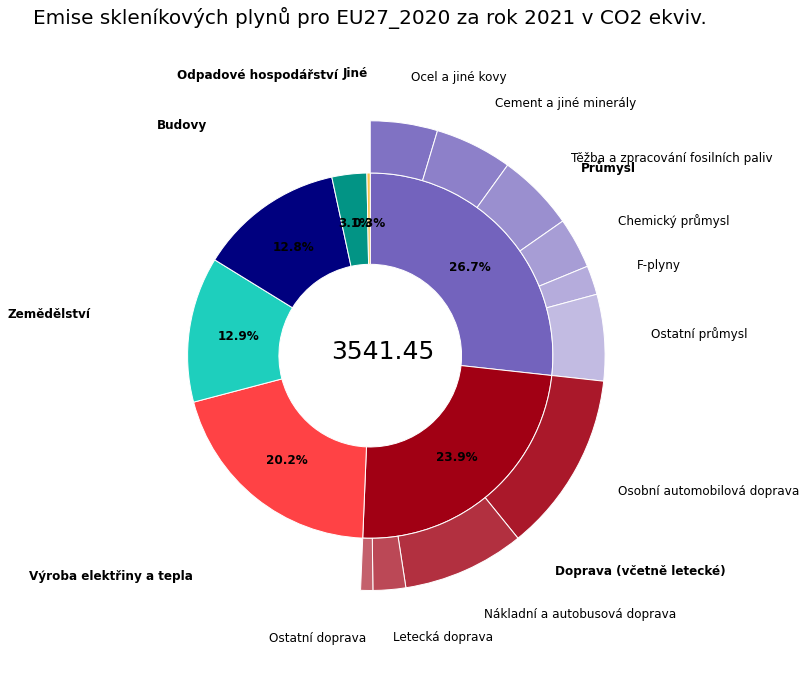

In [6]:
draw_emissions_pie_chart(GEO.value, YEAR, inner_wedges, outer_wedges, total_value)

### 6. Generate accompanying text for the web

Don't forget to update the Google Sheet link!

In [7]:
accompanying_text = f'''---
layout:         infographic
title:          "Emise skleníkových plynů v EU podle sektorů"
slug:           "{strings["slug"]}"
redirect_from:  "/{strings["slug"]}"
published:      2022-07-14
weight:         51
tags-scopes:    [ eu ]
tags-topics:    [ emise ]
caption:        "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v EU za rok {YEAR} v jednotlivých sektorech lidské činnosti. Roční objem emisí Evropské unie je {strings["total-weight"]} mil. tun (údaj z roku {YEAR}). V přepočtu na obyvatele to je {strings["total-per-person"]} tun CO<sub>2</sub>eq/obyvatele."
data-our:       "https://docs.google.com/spreadsheets/d/1SUaWGbKA3TVcXd-ZXH0zNXVZGikcX8iTPJTzGihubHQ/edit?usp=sharing"
data-orig:  [
    ["Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE"]
]
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on {strings["version"]}. Do not change here, fix it in the source notebook."
---

## Jak číst tento graf?

{get_gases_info()}

Roční objem emisí Evropské unie je {czech_float_for_html(total_value, 1)} mil. tun CO<sub>2</sub>eq (údaj z roku {YEAR}). __V přepočtu na obyvatele to je {czech_float_for_html(emissions_per_person, 2)} tun CO<sub>2</sub>eq/obyvatele.__ Zobrazujeme emise EU-27, tedy zemí, které byly k roku {YEAR} členy EU (data tak nezahrnují Velkou Británii).

## Co znamenají jednotlivé sektory?

* {get_sectoral_info(Sector.INDUSTRY, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.TRANSPORT, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.ELECTRICITY_HEAT, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.AGRICULTURE, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.BUILDINGS, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.WASTE, GEO, df_wedges, df, total_value, population)}

{get_lulucf_info(YEAR, GEO, lulucf_emissions)}

## Poznámky k datům o emisích

{get_methodology_info()}

{get_trade_and_flights_info(GEO)}
'''
print(accompanying_text)


---
layout:         infographic
title:          "Emise skleníkových plynů v EU podle sektorů"
slug:           "emise-eu-detail"
redirect_from:  "/emise-eu-detail"
published:      2022-07-14
weight:         51
tags-scopes:    [ eu ]
tags-topics:    [ emise ]
caption:        "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v EU za rok 2021 v jednotlivých sektorech lidské činnosti. Roční objem emisí Evropské unie je 3 541,45 mil. tun (údaj z roku 2021). V přepočtu na obyvatele to je 7,92 tun CO<sub>2</sub>eq/obyvatele."
data-our:       "https://docs.google.com/spreadsheets/d/1SUaWGbKA3TVcXd-ZXH0zNXVZGikcX8iTPJTzGihubHQ/edit?usp=sharing"
data-orig:  [
    ["Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE"]
]
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on 2023-10-04. Do not change here, fix it in the source notebook."
---

## Jak číst tento graf?

Všechny hodnoty v grafu jsou <glossary i

### 7. Generate accompanying text for the web - for the evolution since 1990

In [8]:
YEAR_FROM = 1990

df_from = get_eurostat_crf_data_for_geo(GEO, YEAR_FROM)
total_value_from = get_emissions_value(TOTAL_EMISSION, df_from)
inner_wedges_from = get_emissions_wedges(definition, total_value_from, df_from)
inner_from_dict = {wedge.id: wedge.value for wedge in inner_wedges_from}


#### Fact check

In [9]:
total_from_Gt = total_value_from / 1_000
total_to_Gt = total_value / 1_000
decrease_by_percent = (1 - total_to_Gt / total_from_Gt) * 100

print(f"Emissions have decreased by {decrease_by_percent:.0f}%. Is it still close to 25%?")

Emissions have decreased by 28%. Is it still close to 25%?


In [10]:
accompanying_text = f'''---
layout:        infographic
title:         "Emise skleníkových plynů v EU v letech {YEAR_FROM}–{YEAR}"
slug:          "emise-eu-vyvoj"
redirect_from: "/emise-eu-vyvoj"
published:     2022-01-24
weight:        76
tags-scopes:   [ eu ]
tags-topics:   [ emise, energetika ]
caption:       "Vývoj emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v Evropské unii v jednotlivých sektorech lidské činnosti během let a jejich relativní změny. Od roku {YEAR_FROM}, kdy dosahovaly {czech_float_for_html(total_from_Gt, decimals=1)} miliard tun CO<sub>2</sub>eq, klesly celkové emise EU o jednu čtvrtinu na {czech_float_for_html(total_to_Gt, decimals=1)} miliardy tun CO<sub>2</sub>eq v roce {YEAR}."
data-orig:
  - [ "Náš Jupyter notebook", "https://github.com/faktaoklimatu/data-analysis/blob/master/notebooks/emissions-over-time-eu.ipynb" ]
  - [ "Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE" ]
---

## Jak číst tento graf

{get_gases_info()}

V levé části grafu jsou vyobrazeny absolutní emise Evropské unie (jde o emise EU-27, tj. zemí, které byly k roku {YEAR} členy EU) v jednotkách CO<sub>2</sub>eq od roku {YEAR_FROM} až do roku {YEAR}. Jednotlivé oblasti lidské činnosti jsou barevně odlišeny. V pravé části je pak pro každou z těchto oblastí naznačena relativní změna v objemu emisí oproti roku {YEAR_FROM}.

V roce {YEAR_FROM} činil objem emisí na území dnešní Evropské unie {czech_float_for_html(total_from_Gt)} miliard tun CO<sub>2</sub>eq. V roce {YEAR} to bylo {czech_float_for_html(total_to_Gt)} miliardy tun. To znamená, že během tohoto období klesly emise EU o {decrease_by_percent:.0f} %. Celkové emise EU významněji klesají od roku 2007, tedy po globální finanční krizi, a to ve všech sektorech s výjimkou dopravy.

{{% include preview-box.html
    title="Jak si ve vývoji emisí stojí Česko?"
    text="Obdobnou [infografiku](/infografiky/emise-cr-vyvoj) jsme vytvořili i pro Českou republiku."
    slug="emise-cr-vyvoj"
%}}

## Co vidíme v jednotlivých sektorech

* {get_sectoral_evolution_info(Sector.ELECTRICITY_HEAT, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.TRANSPORT, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.INDUSTRY, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.BUILDINGS, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.AGRICULTURE, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}
* {get_sectoral_evolution_info(Sector.WASTE, GEO, YEAR_FROM, YEAR, inner_from_dict, inner_dict, df_from, df)}

## Poznámky k datům o emisích

{get_methodology_info()}

{get_trade_and_flights_info(GEO)}
'''
print(accompanying_text)


---
layout:        infographic
title:         "Emise skleníkových plynů v EU v letech 1990–2021"
slug:          "emise-eu-vyvoj"
redirect_from: "/emise-eu-vyvoj"
published:     2022-01-24
weight:        76
tags-scopes:   [ eu ]
tags-topics:   [ emise, energetika ]
caption:       "Vývoj emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v Evropské unii v jednotlivých sektorech lidské činnosti během let a jejich relativní změny. Od roku 1990, kdy dosahovaly 4,9 miliard tun CO<sub>2</sub>eq, klesly celkové emise EU o jednu čtvrtinu na 3,5 miliardy tun CO<sub>2</sub>eq v roce 2021."
data-orig:
  - [ "Náš Jupyter notebook", "https://github.com/faktaoklimatu/data-analysis/blob/master/notebooks/emissions-over-time-eu.ipynb" ]
  - [ "Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE" ]
---

## Jak číst tento graf

Všechny hodnoty v grafu jsou <glossary id="antropogennisklenikoveplyny">antropogenní emise</glossary> skleníkových plynů CO<sub>2</sub>, N<sub